In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
from datajanitor.text import create_ngram, remove_stopword, symbols_replaced, decontracted, remove_html_tags, split_words_and_punctuation, apply_text_normalisation
from utils import keep_token_pattern, chain

In [3]:
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')

## Read original dataset

In [4]:
ams_reviews = './amsterdam/reviews.csv'
ams_df = pd.read_csv(ams_reviews)

In [5]:
ams_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [6]:
ams_df.shape

(452637, 6)

In [8]:
non_empty_comment_df = ams_df[~ams_df.comments.isna()]
non_empty_comment_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


## Added language identification to enhance dataset

In [9]:
# from fastText language identification
lang_df = pd.read_csv('with_language_identified.csv', lineterminator='\n')
lang_df.head()

,comments,language,probability
0,daniel is really cool. the place was nice and ...,en,0.992321
1,daniel is the most amazing host! his place is ...,en,0.991255
2,we had such a great time in amsterdam. daniel ...,en,0.995635
3,very professional operation. room is very clea...,en,0.990710
4,daniel is highly recommended. he provided all...,en,0.967161


In [12]:
# any NA?
print("EMPTY ROWS: {}".format(lang_df[lang_df.language.isna()].shape))
lang_df_non_empty = lang_df[(~lang_df.language.isna()) & (~lang_df.comments.isna())]
print("NOT EMPTY ROWS: {}".format(lang_df_non_empty.shape))

EMPTY ROWS: (0, 3)
NOT EMPTY ROWS: (452457, 3)


In [13]:
lang_df['language'].value_counts()[:10]

en    367980
fr     32295
de     17230
es     12225
nl      6627
it      6517
pt      2391
ru      1788
zh      1684
ko       678
Name: language, dtype: int64

In [14]:
### Let's look at the other languages!

print("FRENCH")
print(lang_df[lang_df.language == 'fr'].head(1))
print("GERMAN")
print(lang_df[lang_df.language == 'de'].head(1))
print("SPANISH")
print(lang_df[lang_df.language == 'es'].head(1))

FRENCH
                                             comments language  probability
69  daniel est très hospitalier. il est amical et ...       fr     0.980221
GERMAN
                                             comments language  probability
76  sehr saubere und gepflegte wohnung. daniel war...       de     0.994642
SPANISH
                                              comments language  probability
101  esta ha sido nuestra primera experiencia con a...       es     0.983545


### Add language to main dataset

This is to be used to filter out all non english reviews

In [15]:
non_empty_comment_df.reset_index(inplace=True)
lang_df.reset_index(inplace=True)
print("Number of unique languages found: {}".format(lang_df['language'].nunique()))
joined_df = non_empty_comment_df.join(lang_df[['comments', 'language', 'probability']], rsuffix="_l")

Number of unique languages found: 67


## Explore new dataset

In [16]:
## sample records where review length was less than 2
joined_df[joined_df.comments.apply(lambda x: len(x)<2)].head()

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_l,language,probability
521,521,20168,442764467,2019-04-24,160929563,Justin,q,q,en,0.124504
1090,1090,28658,225376074,2018-01-06,156519085,Yelena Levy,.,.,en,0.213880
3511,3511,47061,112508867,2016-11-06,9300675,Tatyana,-,-,en,0.124504
5524,5526,55256,353526012,2018-11-28,48974801,Kristoffer,.,.,en,0.213880
9367,9370,82482,435014347,2019-04-09,98927426,Gabriele,.,.,en,0.213880


In [37]:
joined_df['review_length'] = joined_df['comments'].apply(lambda x: len(x))
joined_df['sentence_length'] = joined_df['comments'].apply(lambda x: len(x.split(" ")))

In [40]:
# Review length
joined_df.review_length.min(), joined_df.review_length.max(), joined_df.review_length.mean()

(1, 5620, 293.4360353710044)

In [41]:
# Sentence length
joined_df.sentence_length.min(), joined_df.sentence_length.max(), joined_df.sentence_length.mean()

(1, 1000, 51.73906480337532)

### Length of english reviews given

In [46]:
eng_reviews_df = joined_df[(joined_df.language == 'en') & (joined_df.probability > 0.5)]
print("Size of english review dataset: {}".format(eng_reviews_df.shape))

Size of english review dataset: (365217, 12)


In [62]:
print("Number of short reviews (words): {}".format(eng_reviews_df[eng_reviews_df.sentence_length < 2].shape))
print("Number of long reviews (words): {}".format(eng_reviews_df[eng_reviews_df.sentence_length >= 100].shape))

Number of short reviews (words): (370, 12)
Number of long reviews (words): (44384, 12)


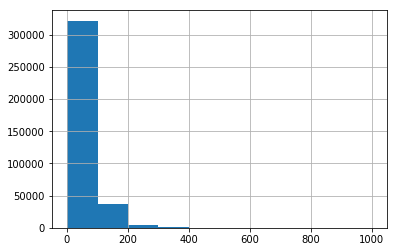

In [50]:
eng_reviews_df['sentence_length'].hist()

In [54]:
print("One word reviews: {}".format(eng_reviews_df[eng_reviews_df.sentence_length == 1].shape))

One word reviews: (370, 12)


In [56]:
eng_reviews_df[eng_reviews_df.sentence_length == 1].tail()

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_l,language,probability,review_length,sentence_length
450560,450735,31998790,440122148,2019-04-20,50672837,Nahuel,Perfection.,perfection.,en,0.758678,11,1
450561,450736,31998802,412335433,2019-02-15,241910834,Loris,Nice,nice,en,0.633955,4,1
450675,450850,32067350,438667495,2019-04-17,41938005,Henrik,Perfect.,perfect.,en,0.882706,8,1
451955,452131,33159282,448328219,2019-05-05,254275704,Jasmina,perfect,perfect,en,0.663002,7,1
452186,452362,33477670,438695491,2019-04-17,248203373,Diogo,Perfect,perfect,en,0.663002,7,1


One word reviews do not much meaningful context into how their experience went - Ok, Nice, Perfect. Do they really mean it? Are they ok in every aspect - location, price, place itself? Hence single word reviews will be excluded.

In [66]:
eng_reviews_v2_df = eng_reviews_df[eng_reviews_df.sentence_length > 2]

### Host cancellation penalty

In [92]:
automated_postings = eng_reviews_v2_df[eng_reviews_v2_df.comments.str.contains("The host canceled this reservation")]
print("Number of reviews that were automated postings: {}".format(automated_postings.shape))

Number of reviews that were automated postings: (7004, 13)


Airbnb tends to post automated reviews when a host cancels a reservation. These are penalties imposed by Airbnb on Host. This should be treated separately from analysing guest reviews.

## Cleaning and tokenising reviews

In [118]:
from nltk.stem.snowball import SnowballStemmer

sb = SnowballStemmer("english").stem

def join_tokens(token_list):
    return " ".join(token_list)

operations = [{"function": symbols_replaced},
              {"function": decontracted},
              {"function": remove_html_tags},
              {"function": split_words_and_punctuation},
              {"function": remove_stopword, "stopword_list": english_stop_words},
              {"function": keep_token_pattern, "pattern": '[a-zA-Z]{3,}'},
#               {"function": apply_text_normalisation, "func": sb},
              {"function": join_tokens}
#               {"function": create_ngram, "n": 2}
             ]

In [119]:
eng_reviews_v2_df['comments_cleaned'] = eng_reviews_v2_df['comments'].apply(lambda x: chain(x.lower(), operations))

/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [120]:
eng_reviews_v2_df['comments_token'] = eng_reviews_v2_df['comments_cleaned'].apply(lambda x: apply_text_normalisation(x.split(" "), sb))

/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [125]:
eng_reviews_v2_df['comments_token_str'] = eng_reviews_v2_df['comments_token'].apply(lambda x: " ".join(x))

/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
eng_reviews_v2_df.to_json("preprocessed_english_reviews.json", orient="records")

### Term Frequency Inverse Document Frequency

Tfidf used to highlight important words from the reviews. Words which are used frequently within the same document and across documents are not given high weighting as they are treated as common words. Words which appear frequently within few documents on the other hand makes the words more important and relevant.

In [87]:
grouped_eng_reviews = eng_reviews_v2_df.groupby('listing_id')

#### Using only unigrams

In [89]:
def dummy_fun(token):
    return token

count_vectorizer2 = TfidfVectorizer(
                        strip_accents='unicode',
                        preprocessor=dummy_fun,
                        analyzer='word',
                        ngram_range=(1, 1),
                        min_df=10,
                        use_idf=True, smooth_idf=True, 
                        max_features = 1000)

bag_of_words2 = count_vectorizer2.fit_transform(eng_reviews_v2_df['comments_token'])
print(bag_of_words2.shape)

(362300, 1000)


In [93]:
for listing_id, gdf in grouped_eng_reviews:
    print("Number of reviews for listing#{}: {}".format(listing_id, gdf['comments_token'].shape))
    listing_words = count_vectorizer2.transform(gdf['comments_token'])
    feature_names = count_vectorizer2.get_feature_names()
    top_tokens = print_top_tokens(feature_names, listing_words)
    print([token[0] for token in top_tokens])
    break

Number of reviews for listing#2818: (211,)
['daniel', 'stay', 'room', 'host', 'clean', 'place', 'amsterdam', 'great', 'map', 'provid']


Unigrams themselves do not provide much insight into reviews that were given for Listing #2818.

The only 3 points I can understand from the top 10 tokens are:
1. The host is Daniel (which is irrelevant information we do not want to know via reviews)
2. Most guests have stayed in private rooms (again irrelevant information since we will already know this via the listing itself)
3. Most guests think that his room is clean (Finally a relevant piece of information!)

#### Using bigram

In [124]:
count_vectorizer = TfidfVectorizer(
                        strip_accents='unicode',
                        preprocessor=None,
                        analyzer='word',
                        ngram_range=(2, 2),
                        min_df=10,
                        use_idf=True, smooth_idf=True, 
                        max_features = 1000)

bag_of_words = count_vectorizer.fit_transform(eng_reviews_v2_df['comments_token'])
print(bag_of_words.shape)

AttributeError: 'list' object has no attribute 'lower'

In [123]:
import pickle
with open('ams_tfidf_vectorizer.pkl', 'wb') as pklfile:
    pickle.dump(count_vectorizer, file=pklfile)

In [113]:
for listing_id, gdf in grouped_eng_reviews:
    print("Number of reviews for listing#{}: {}".format(listing_id, gdf['comments_token'].shape))
    listing_words = count_vectorizer.transform(gdf['comments_token'])
    feature_names = count_vectorizer.get_feature_names()
    top_tokens = print_top_tokens(feature_names, listing_words)
    print([token[0] for token in top_tokens])
    break

Number of reviews for listing#2818: (211,)
['great host', 'perfect host', 'public transport', 'high recommend', 'place clean', 'get around', 'make sure', 'stay amsterdam', 'recommend stay', 'host place']


There we go! With using bigrams, we start to get some interesting insight into guests' experience at Listing#2818.
1. The host was great and some might even say perfect :)
2. Guests talked about public transport and accessibilty of listing to their points of interest
3. The place was clean
4. That most of them highly recommend the place.

In [99]:
listing_2818 = grouped_eng_reviews.get_group(2818)
listing_2818[listing_2818['comments'].str.contains("get around")]['comments'].tolist()

['Daniele is an amazing host! He provided everything that was needed to make our stay comfortable and easy! The rooms were clean and cozy; and he took the time to show us how to get around Amsterdam via public transportation or riding around on bicycles. You truly do feel like a local when staying with Daniele!!\r\n',
 "Staying at Daniel's apartment was great! My boyfriend and I stayed here two nights and were very happy to do so. Daniel was a terrific host who made us feel at home. The room we stayed in was lovely and comfortable, and he provided us with a hair dryer, towels, tea and coffee, maps and guide books. He was a wealth of information in terms of when to go to certain museums, what was and wasn't worthwhile, and the best ways to get around using public transportation. He even allowed us to use his bikes free of charge! He was very accommodating and accepted our booking very last minute, and didn't mind that we were arriving late in the evening on a weeknight. The location of 

#### Apply on reviews of last 6 months

Using bigram has given us much better insight to guest reviews. But reviews used earlier were based on all guests from the first guest(s) to the most recent guest(s). While factors like location would not have changed during the lifetime of listing, other factors like communication, cleanliness, check-in progress, amenities and decor of the listing could have changed - for the better or worse?! I would like to think mostly for the better where hosts have become more experience with each review given by their guest.

Therefore, lets try to extract only key terms used in reviews submitted in the last 6 months.

In [108]:
import datetime
today = datetime.date.today()

datetime.date(2019, 5, 24)

In [114]:
duration = 30*6

for listing_id, gdf in grouped_eng_reviews:
    gdf['formatted_date'] = gdf['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
    most_recent = gdf[gdf['formatted_date'] > today - datetime.timedelta(days=duration)]
    print("Number of reviews for listing#{}: {}".format(listing_id, most_recent['comments_token'].shape))
    listing_words = count_vectorizer.transform(most_recent['comments_token'])
    feature_names = count_vectorizer.get_feature_names()
    top_tokens = print_top_tokens(feature_names, listing_words, 20)
    print([token[0] for token in top_tokens])
    break

Number of reviews for listing#2818: (7,)
['quiet neighborhood', 'high recommend', 'room great', 'host made', 'great room', 'amsterdam high', 'love amsterdam', 'feel welcom', 'first day', 'mani thank', 'great recommend', 'place everyth', 'went way', 'super help', 'local tip', 'made feel', 'gave great', 'good time', 'minut tram', 'minut citi']


/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """


Key terms between the last 6 months VS all time has definitely changed slightly.

The overall opinion are:
1. the host is great
2. listing at a good location
3. place is clean.
4. they would recommend the listing

In the 6 months, guests have commented on:
1. the host is great, welcoming, super helpful
2. listing at a quiet neighborhood
3. place is great
4. they had a good time and would recommend the listing.
    

#### Lets see if we agree with the key terms found

In [132]:
duration = 30*6
listing_2818 = grouped_eng_reviews.get_group(2818)
listing_2818['formatted_date'] = listing_2818['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
most_recent_2818 = listing_2818[listing_2818['formatted_date'] > today - datetime.timedelta(days=duration)]

/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """


In [135]:
most_recent_2818['comments'].tolist()

['This is an outstanding place to stay. Everything is spotless but very comfortable. It’s in a quiet neighborhood outside of the bustling downtown, but a close 15 minutes by tram. Daniel went out of his way to be helpful with directions and things to do. He even sent me a note on our first day asking if we were having a good time. I highly recommend this AirBnB and would definitely stay here again.',
 'Daniel’s place was great! The room was close to downtown and very clean. Daniel is kind and accommodating and gave us great recommendations and tips for our trip to Amsterdam. I highly recommend this location!',
 'Daniel was such a great host!  He made me feel very welcome. I found all his directions and local knowledge invaluable. He was very easy to contact before and during my stay and nothing was too much trouble :). The room was great! comfortable and convenient. Great location!',
 "Daniel's living quarters is very clean and cosy! He is a thoughtful host who make sure guests are com

The top 20 key terms have definitely addressed reviews received in the last 6 months. The only point that wasn't mentioned was about the location - convenient/accessible via public transportation. That's understandable given that different guests have described it slightly different.

1) a close 15 minutes by tram

2) with the centraal around 20mins away via bus/tram

3) Public transportation is 5 minutes from the apartment

4) very easily accessible by tram or bus

In [80]:
import operator

def print_top_tokens(feature_names, word_counts, n_top=10):
    tdidf_counts = zip(feature_names, word_counts.sum(axis=0).tolist()[0])
    sorted_x = sorted(dict(tdidf_counts).items(), key = operator.itemgetter(1), reverse = True)

    if n_top:
        return sorted_x[: n_top]
    else:
        return sorted_x